# Machine Learning 2023/2024

## Third Home Assignment

**Group Number:** 10

**Group Elements:**
- André Santos (fc53323)
- Filipe Santos (fc53304)
- João Martins (fc62532)
- Rúben Torres (fc62531)

**Hours Worked:**
- André Santos (24h)
- Filipe Santos (24h)
- João Martins (26h)
- Rúben Torres (24h)

### Imports

In [64]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, 
    BaggingRegressor, 
    AdaBoostRegressor, 
    GradientBoostingRegressor
)
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import (
    explained_variance_score, 
    mean_squared_error, 
    max_error, 
    mean_absolute_error,
)
from scipy.stats import pearsonr
from sklearn.preprocessing import ( 
    StandardScaler, 
    PowerTransformer,  
    QuantileTransformer, 
    Normalizer,
) 
from sklearn.decomposition import (
    PCA, 
    KernelPCA,
)
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel


In [40]:
def printAvalStat(truth, preds):
    print(" The RVE is: ", explained_variance_score(truth, preds))
    print(" The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval=pearsonr(truth, preds)
    print(" The Correlation Score is: %6.4f (p-value=%e)\n"%(corr,pval))

    print(" The Maximum Error is: ", max_error(truth, preds))
    print(" The Mean Absolute Error is:", mean_absolute_error(truth, preds),"\n")

def nfold_valid_RVE_RMSE(X_train_Valids, y_train, mdl):
    kf = KFold(n_splits=5, shuffle=True, random_state=23)
    kf.get_n_splits(X_train_Valids)
    TRUTH_nfold=None
    PREDS_nfold=None
    for train_index, test_index in kf.split(X_train_Valids):
        X_train_nfold, X_ivs_nfold = X_train_Valids[train_index], X_train_Valids[test_index]
        y_train_nfold, y_ivs_nfold = y_train[train_index], y_train[test_index]

        mdl.fit(X_train_nfold, y_train_nfold)
        preds = mdl.predict(X_ivs_nfold)
        if TRUTH_nfold is None:
            PREDS_nfold=preds
            TRUTH_nfold=y_ivs_nfold
        else:
            PREDS_nfold=np.hstack((PREDS_nfold, preds))
            TRUTH_nfold=np.hstack((TRUTH_nfold, y_ivs_nfold))
        
    return explained_variance_score(TRUTH_nfold, PREDS_nfold),mean_squared_error(TRUTH_nfold, PREDS_nfold, squared=False)

In [41]:
def nfold_valid(X_train_Valids, y_train, mdl):
    kf = KFold(n_splits=5, shuffle=True, random_state=23)
    kf.get_n_splits(X_train_Valids)
    TRUTH_nfold=None
    PREDS_nfold=None
    for train_index, test_index in kf.split(X_train_Valids):
        X_train_nfold, X_ivs_nfold = X_train_Valids[train_index], X_train_Valids[test_index]
        y_train_nfold, y_ivs_nfold = y_train[train_index], y_train[test_index]

        mdl.fit(X_train_nfold, y_train_nfold)
        preds = mdl.predict(X_ivs_nfold)
        if TRUTH_nfold is None:
            PREDS_nfold=preds
            TRUTH_nfold=y_ivs_nfold
        else:
            PREDS_nfold=np.hstack((PREDS_nfold, preds))
            TRUTH_nfold=np.hstack((TRUTH_nfold, y_ivs_nfold))
        
    printAvalStat(TRUTH_nfold, PREDS_nfold)

### Loading and understanding the Dataset

In [42]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
N,M=X_train.shape
print(X_train.shape)


(7337, 2132)


In [72]:
print(min(y_train))

0.0


<h3>Scaling Data with different scalers

In [109]:
sScaler = StandardScaler()
sScaler.fit(X_train)
X_train_scaled = sScaler.transform(X_train)
X_ivs_scaled = sScaler.transform(X_ivs)

pT_scaler = PowerTransformer()
pT_scaler.fit(X_train)
X_train_power_t = pT_scaler.transform(X_train)
X_ivs_power_t = pT_scaler.transform(X_train)

X_train_normal_transform = QuantileTransformer(output_distribution="normal", random_state=25).fit_transform(X_train)

X_train_uniform_transform = QuantileTransformer(output_distribution="uniform", random_state=25).fit_transform(X_train)

X_train_normalizer_t = Normalizer().fit_transform(X_train)


c:\Users\joaom\Documents\FCUL\1ºSemestre\Aprendizagem Automática\Home assignments\.env\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\joaom\Documents\FCUL\1ºSemestre\Aprendizagem Automática\Home assignments\.env\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [44]:
def featureSelect(x_train, n_features, t):
    rfr=RandomForestRegressor(random_state=0, n_jobs=6)
    rfr.fit(x_train, y_train)

    
    sel = SelectFromModel(estimator=rfr, threshold= t) #Change the threshold! See what happens!
    sel.fit(x_train, y_train)
    
    
    features=sel.get_support()
    Features_selected =np.arange(n_features)[features]
    print("The features selected are columns: ", Features_selected,".\n Number of features:", len(Features_selected))
    
    X_train_rffs=sel.transform(x_train)
    return X_train_rffs

In [45]:
def test_scalers(name, featureSelected, mdl):
    x = list()
    rve = list()
    rmse = list()
    print(f"{name}")
    for X_features in featureSelected:
        x.append(X_features.shape[1])
        RVE, RMSE = nfold_valid_RVE_RMSE(X_features, y_train, mdl)
        rve.append(RVE)
        rmse.append(RMSE)

    print(f"RVE: {max(rve)}")
    print(f"RMSE: {min(rmse)}")
    plt.plot(x, rve, marker="o")
    plt.plot(x, rmse, marker="o")
    plt.grid()
    plt.show()

### Testing diferent values for feature selection

The features selected are columns:  [  11   25   26   32   37   38  959 1054 1285 1709] .
 Number of features: 10
The features selected are columns:  [  11   25   26   32   37   38   41  494  839  853  959  982 1054 1285
 1598 1709] .
 Number of features: 16
The features selected are columns:  [  11   25   26   27   29   32   34   37   38   40   41   42  494  839
  853  886  909  959  982 1054 1285 1598 1709] .
 Number of features: 23
The features selected are columns:  [   1   11   22   25   26   27   29   30   31   32   33   34   35   36
   37   38   39   40   41   42  336  364  494  839  853  886  909  939
  959  982 1054 1285 1598 1687 1709 1922] .
 Number of features: 36
The features selected are columns:  [   0    1    2    3    4    5    6    8    9   11   12   16   22   23
   24   25   26   27   28   29   30   31   32   33   34   35   36   37
   38   39   40   41   42  216  246  287  316  336  348  353  362  364
  444  494  561  819  839  853  886  891  909  939  959  981  982 

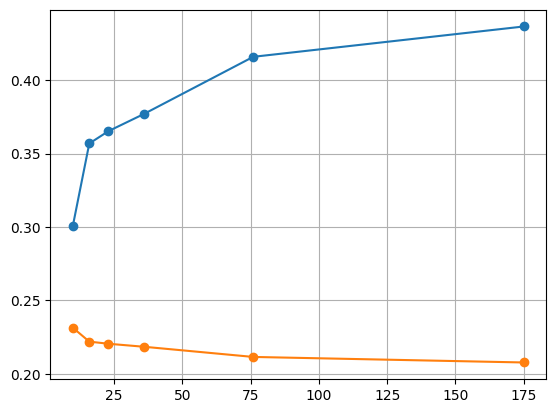

Linear Regression
RVE: 0.4423185057504412
RMSE: 0.20658783571337347


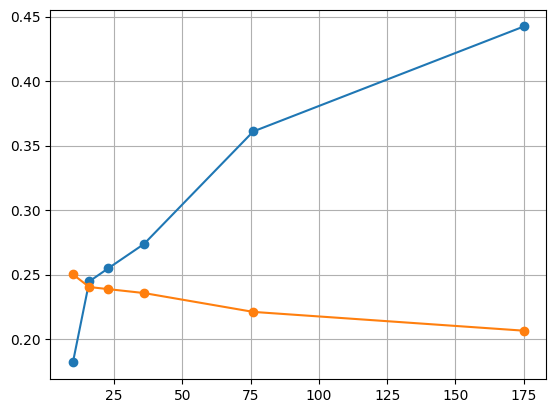

Decision Tree
RVE: 0.28886196386761465
RMSE: 0.23328695397775145


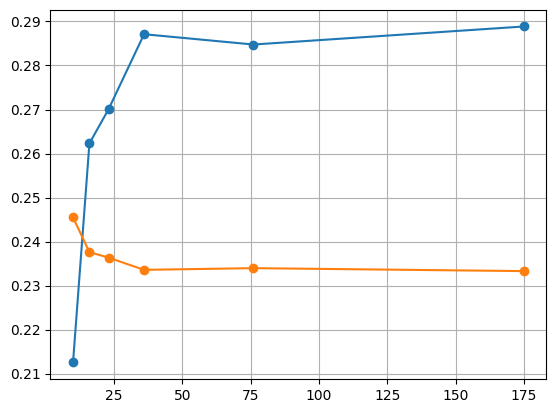

KNN
RVE: 0.5938216904630924
RMSE: 0.1763687320087657


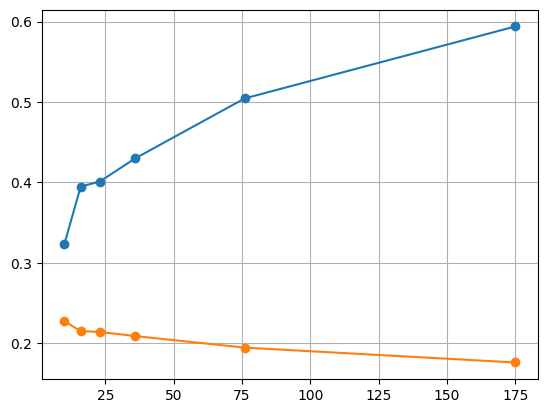

SVR
RVE: 0.6357111647020437
RMSE: 0.16702779171234122


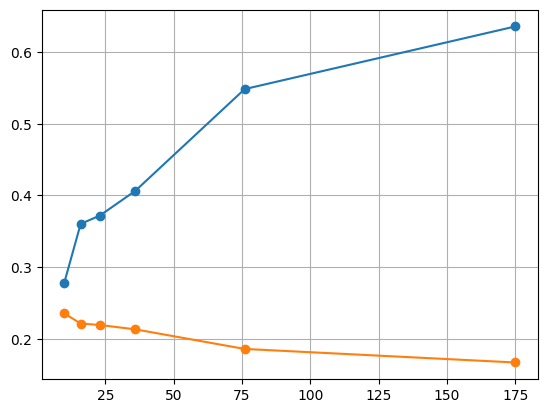

In [46]:
threshold = [.01, .008, .006, .004, .002, .0008, .0004, .00009]

features = list()
for i in threshold:
    features.append(featureSelect(X_train_scaled, X_train_scaled.shape[1], i))


RFR_mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_scalers("Random forest", features, RFR_mdl)


LR_mdl = LinearRegression(n_jobs=6)
test_scalers("Linear Regression", features, LR_mdl)


DTR_mdl = DecisionTreeRegressor(max_depth=5)
test_scalers("Decision Tree", features, DTR_mdl)


KNN_mdl = KNeighborsRegressor(n_jobs=6)
test_scalers("KNN", features, KNN_mdl)


SVR_mdl = SVR()
test_scalers("SVR", features, SVR_mdl)

### PCA and KPCA

In [47]:
def pca(x_train, n_comps):
    pca = PCA(n_components=n_comps)
    pca.fit(x_train)
    X_train_pca = pca.transform(x_train) 
    return X_train_pca

def kpca(x_train, n_comps):
    kpca = KernelPCA(n_components=n_comps, kernel='rbf', n_jobs=4)#, gamma=3)
    kpca.fit(x_train)
    X_train_kpca = kpca.transform(x_train)
    return X_train_kpca

In [58]:
def test_PCA(name, threshold, mdl, X_train_scaled):
    x = list()
    rve = list()
    rmse = list()
    print(f"{name}")
    for i in threshold:
        X_train_pca = pca(X_train_scaled, i)
        x.append(X_train_pca.shape[1])
        RVE, RMSE = nfold_valid_RVE_RMSE(X_train_pca, y_train, mdl)
        rve.append(RVE)
        rmse.append(RMSE)

    print(f"RVE: {max(rve)}")
    print(f"RMSE: {min(rmse)}")
    plt.plot(x, rve, marker="o")
    plt.plot(x, rmse, marker="o")
    plt.grid()
    plt.show()

def test_KPCA(name, threshold, mdl, X_train_scaled):
    x = list()
    rve = list()
    rmse = list()
    print(f"{name}")
    for i in threshold:
        X_train_kpca = kpca(X_train_scaled, i)
        x.append(X_train_kpca.shape[1])
        RVE, RMSE = nfold_valid_RVE_RMSE(X_train_kpca, y_train, mdl)
        rve.append(RVE)
        rmse.append(RMSE)

    print(f"RVE: {max(rve)}")
    print(f"RMSE: {min(rmse)}")
    plt.plot(x, rve, marker="o")
    plt.plot(x, rmse, marker="o")
    plt.grid()
    plt.show()

### Testing diferent values for PCA
#### Random Forest Regressor

Standard
RVE: 0.4308562641285707
RMSE: 0.2087009173558701


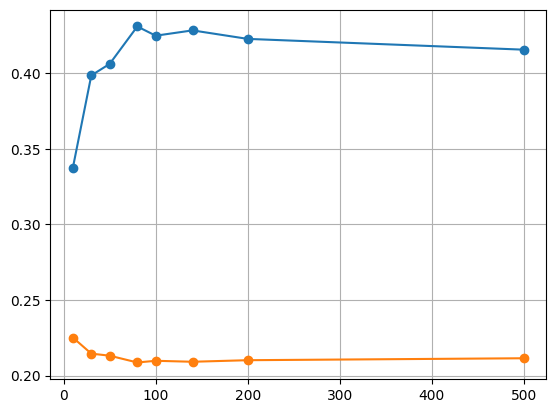

Power Transformer
RVE: 0.42457737254976324
RMSE: 0.20985702404311105


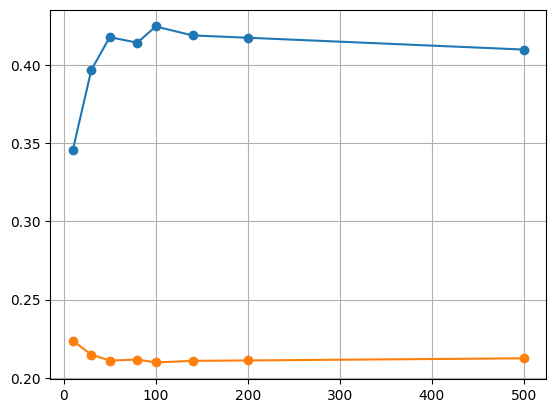

Quality normal
RVE: 0.4221132110227649
RMSE: 0.21030081398567263


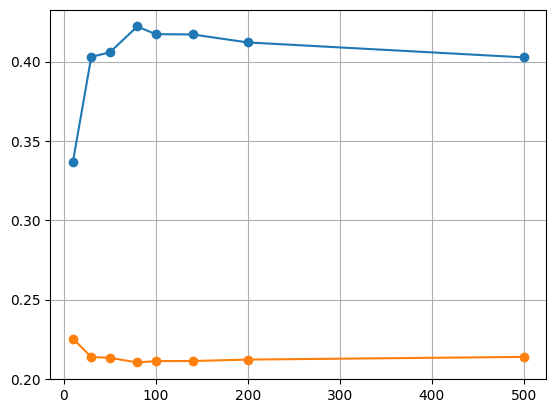

Quality Uniform
RVE: 0.44014343123351896
RMSE: 0.20699962941112365


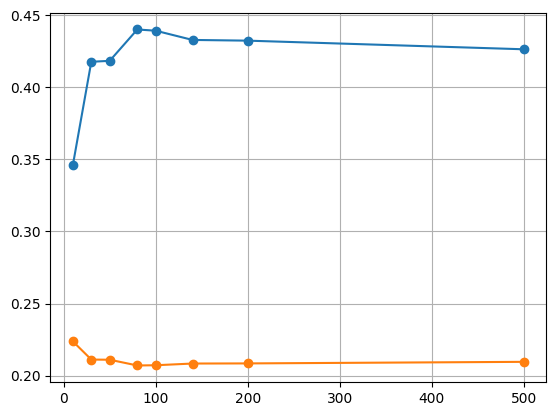

Normalizer
RVE: 0.4011981746303376
RMSE: 0.21407275533129164


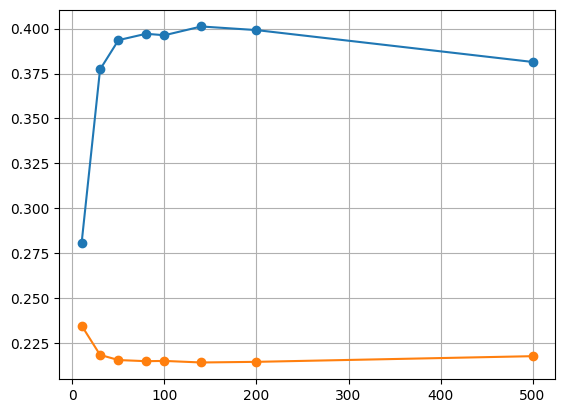

In [50]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_PCA("Standard", threshold, mdl, X_train_scaled)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_PCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_PCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_PCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_PCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### Linear Regression

Standard
RVE: 0.5274295746440476
RMSE: 0.1901717753537191


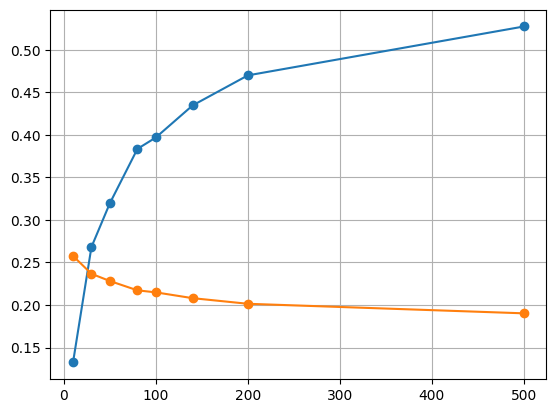

Power Transformer
RVE: 0.5288970794661808
RMSE: 0.1898758714815191


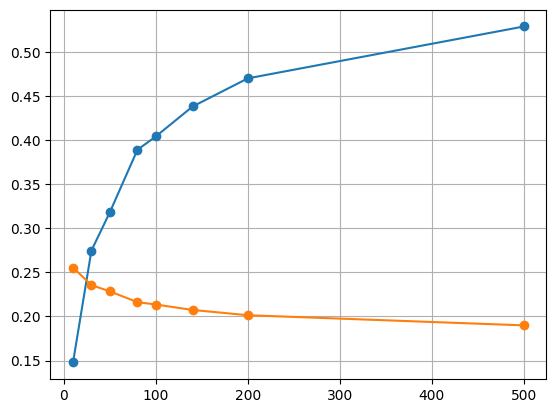

Quality normal
RVE: 0.5499508759860995
RMSE: 0.1855852508923163


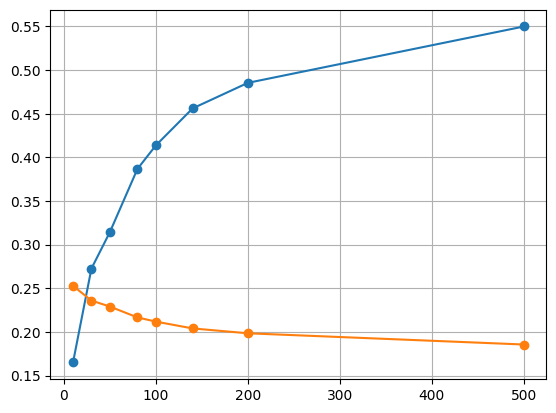

Quality Uniform
RVE: 0.546306350805482
RMSE: 0.1863356895398292


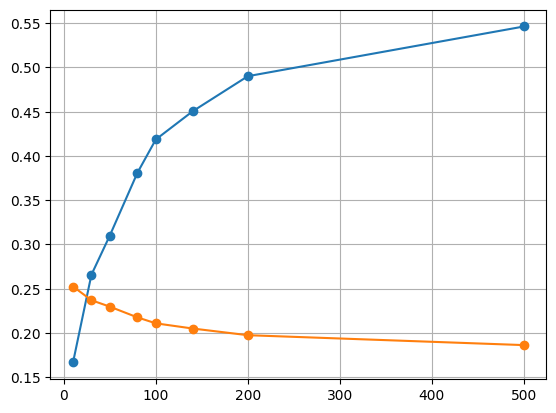

Normalizer
RVE: 0.5394553729265048
RMSE: 0.18773704250762047


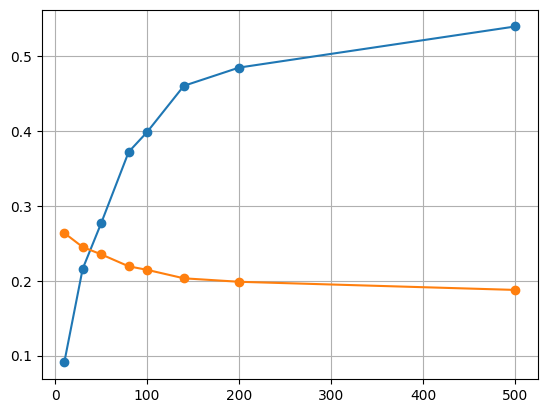

In [51]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = LinearRegression(n_jobs=10)
test_PCA("Standard", threshold, mdl, X_train_scaled)

mdl = LinearRegression(n_jobs=10)
test_PCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = LinearRegression(n_jobs=10)
test_PCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = LinearRegression(n_jobs=10)
test_PCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = LinearRegression(n_jobs=10)
test_PCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### K-neighbors Regressor

Standard
RVE: 0.6042434302094485
RMSE: 0.1740306780898447


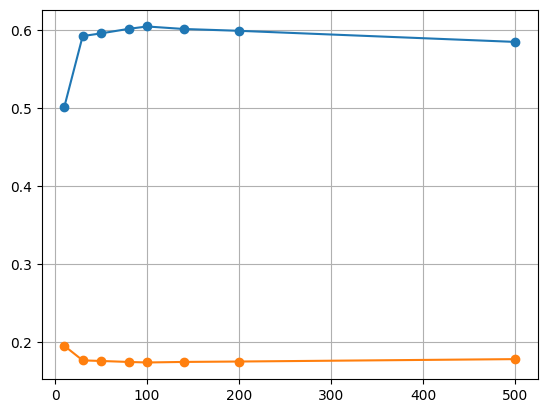

Power Transformer
RVE: 0.607839006938782
RMSE: 0.17324637395977283


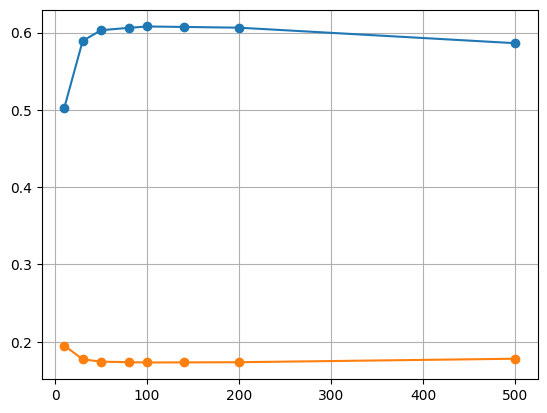

Quality normal
RVE: 0.6292977278765919
RMSE: 0.168436672543076


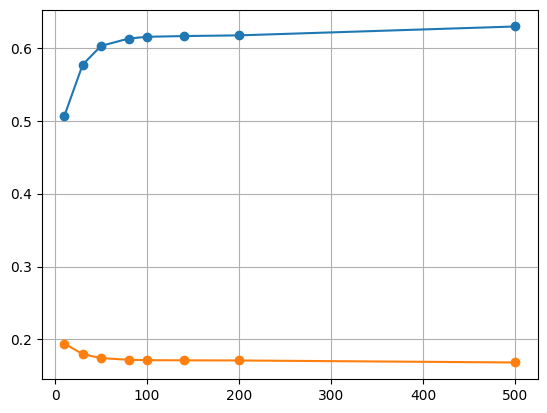

Quality Uniform
RVE: 0.631024467522382
RMSE: 0.16805551127991594


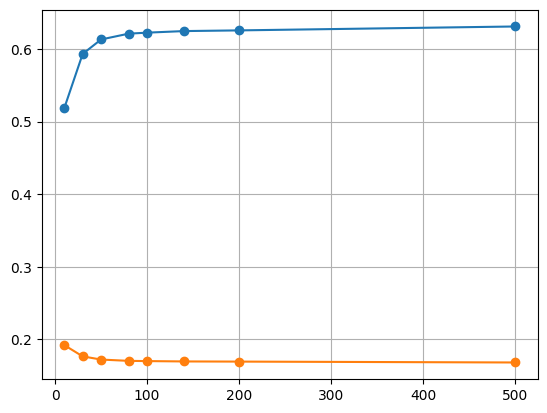

Normalizer
RVE: 0.45675726887852763
RMSE: 0.2047049377185856


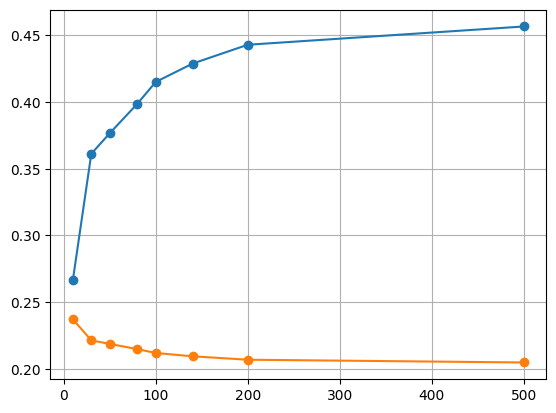

In [52]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = KNeighborsRegressor(n_jobs=6)
test_PCA("Standard", threshold, mdl, X_train_scaled)

mdl = KNeighborsRegressor(n_jobs=6)
test_PCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = KNeighborsRegressor(n_jobs=6)
test_PCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = KNeighborsRegressor(n_jobs=6)
test_PCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = KNeighborsRegressor(n_jobs=6)
test_PCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### Support Vector Regressor

Standard
RVE: 0.649511049152984
RMSE: 0.16381875994975184


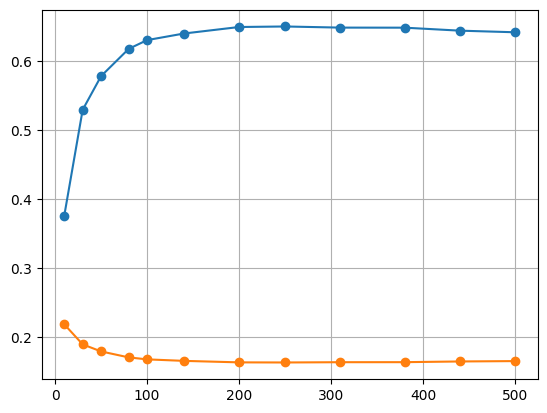

Power Transformer
RVE: 0.6511509301553257
RMSE: 0.1634263290793149


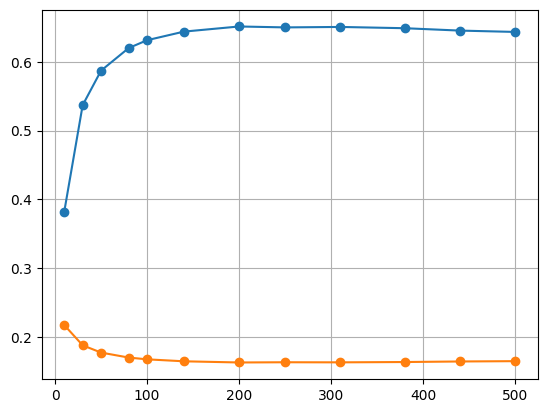

Quality normal
RVE: 0.6668086249171342
RMSE: 0.15975816523963474


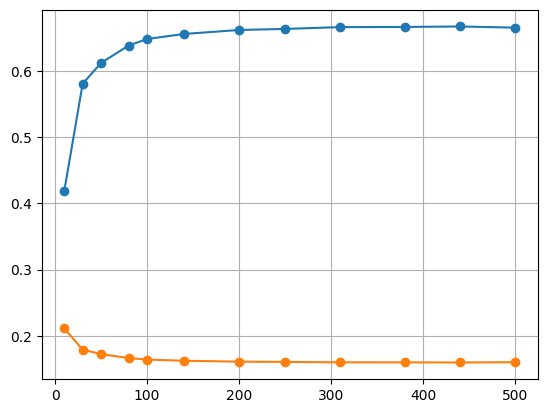

Quality Uniform
RVE: 0.670402236283983
RMSE: 0.15889579263985742


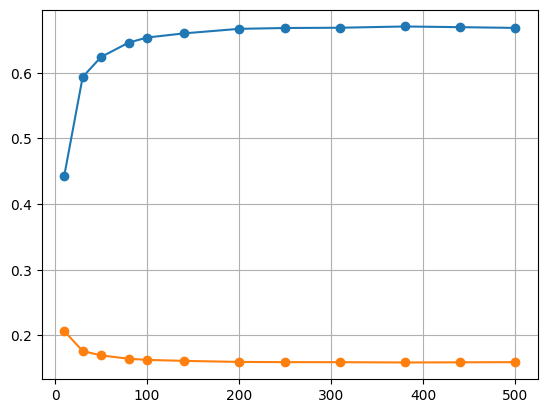

Normalizer
RVE: 0.6056411012248145
RMSE: 0.17372312409018453


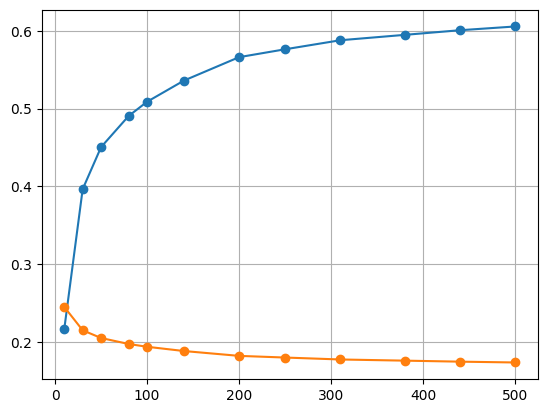

In [66]:
threshold = [10, 30, 50, 80, 100, 140, 200, 250, 310, 380, 440, 500]

mdl = SVR()
test_PCA("Standard", threshold, mdl, X_train_scaled)

mdl = SVR()
test_PCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = SVR()
test_PCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = SVR()
test_PCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = SVR()
test_PCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### XGB Regressor

Standard
RVE: 0.5991538288549795
RMSE: 0.17649933024312772


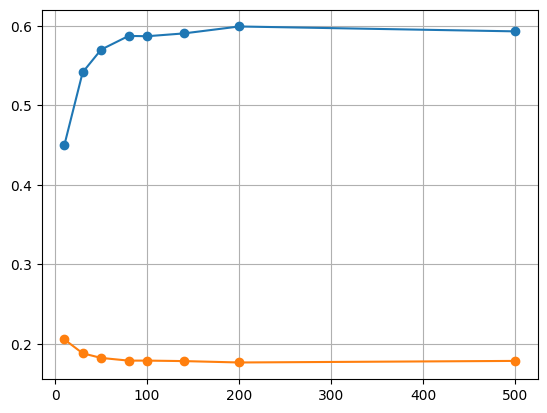

Power Transformer
RVE: 0.6026190837334406
RMSE: 0.17552473319197645


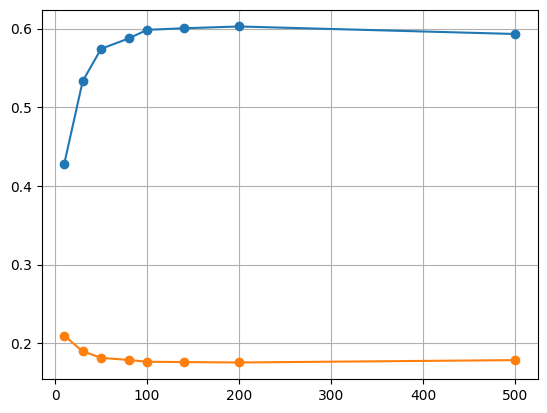

Normalizer
RVE: 0.6042428963486803
RMSE: 0.17528277039000154


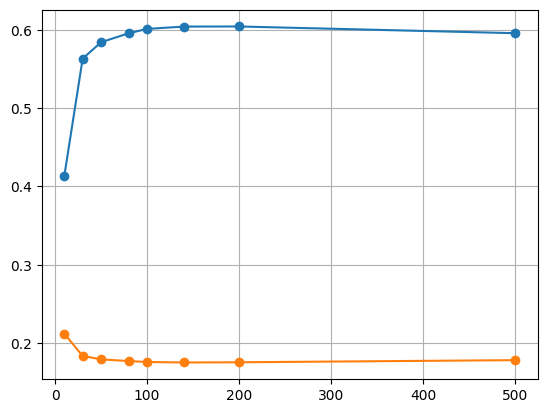

In [65]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]

mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                   objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
test_PCA("Standard", threshold, mdl, X_train_scaled)

mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                   objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27)
test_PCA("Power Transformer", threshold, mdl, X_train_power_t)

# mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
#                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# test_PCA("Quality normal", threshold, mdl, X_train_normal_transform)

# mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
#                    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
# test_PCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                   objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27)
test_PCA("Normalizer", threshold, mdl, X_train_normalizer_t)

### Kernel PCA
#### Random Forest Regressor

Standard
RVE: 0.43806772834843655
RMSE: 0.20737745690923157


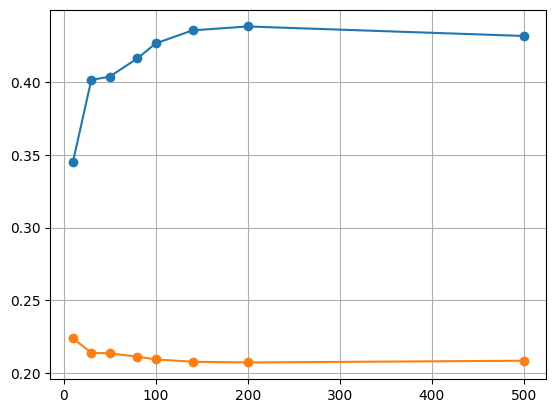

Power Transformer
RVE: 0.42089906224416207
RMSE: 0.21051760896915805


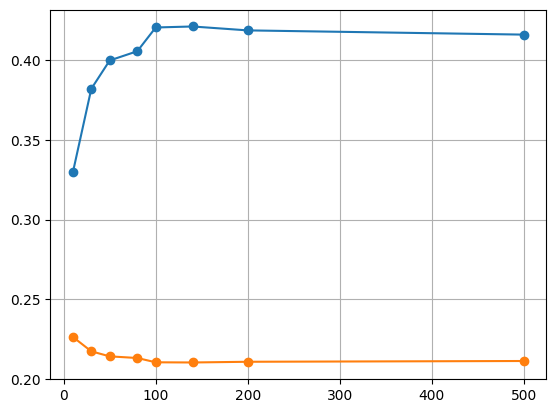

Quality normal
RVE: 0.46169644334927273
RMSE: 0.20296828240443507


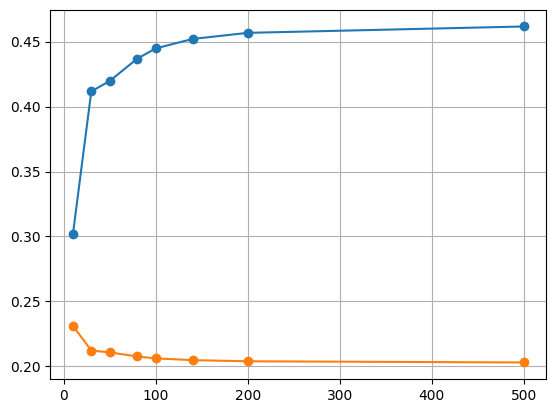

Quality Uniform
RVE: 0.4366805579496854
RMSE: 0.20763970187782402


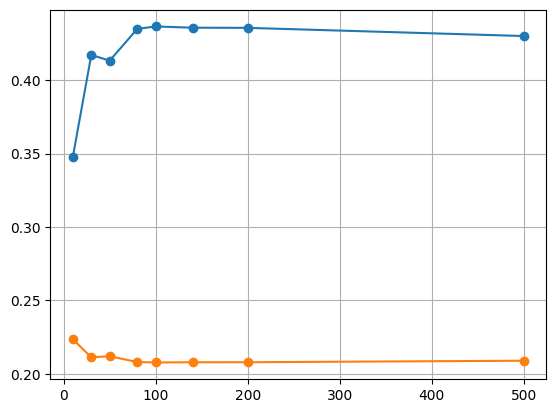

Normalizer
RVE: 0.399078252463968
RMSE: 0.21444704986701174


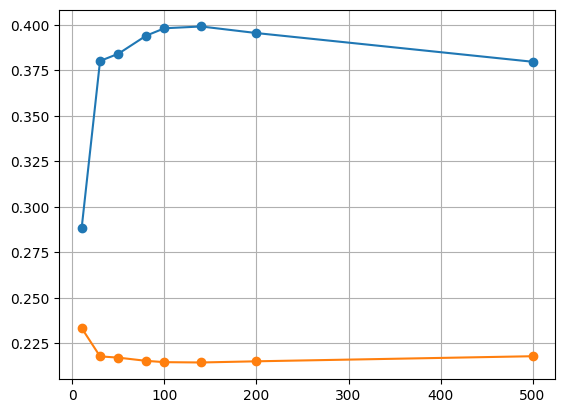

In [59]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_KPCA("Standard", threshold, mdl, X_train_scaled)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_KPCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_KPCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_KPCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
test_KPCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### Linear Regressor

Standard
RVE: 0.5575668380282065
RMSE: 0.18400722484575693


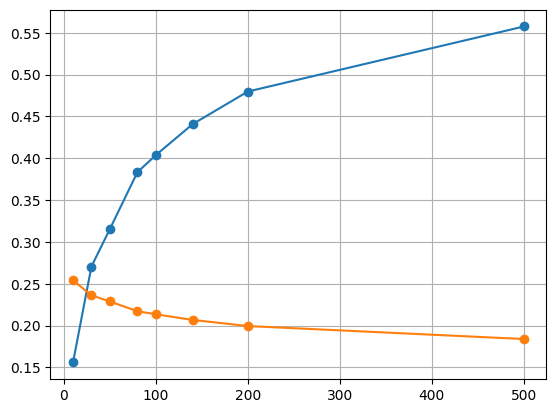

Power Transformer
RVE: 0.5557099629221763
RMSE: 0.18439294744714024


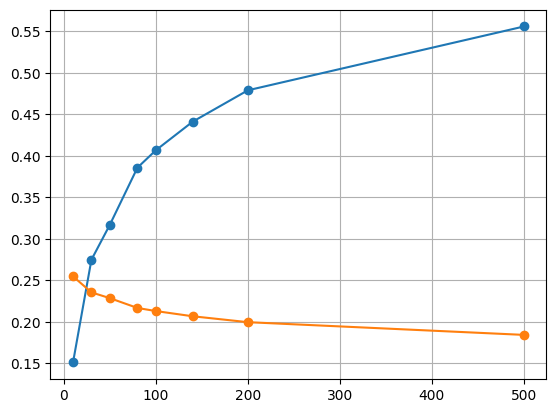

Quality normal
RVE: 0.4262462831825856
RMSE: 0.2095433708271653


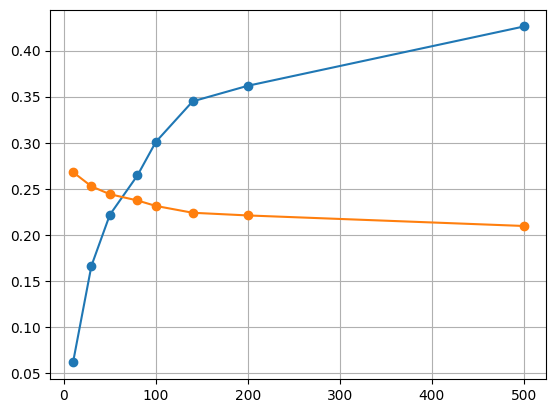

Quality Uniform
RVE: 0.5523185158895771
RMSE: 0.18509735509091343


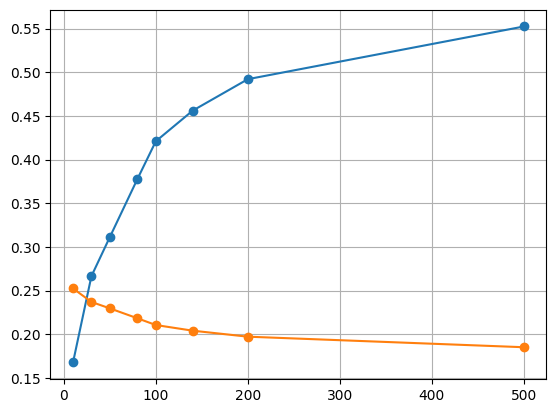

Normalizer
RVE: 0.5351227801639493
RMSE: 0.18861728982820922


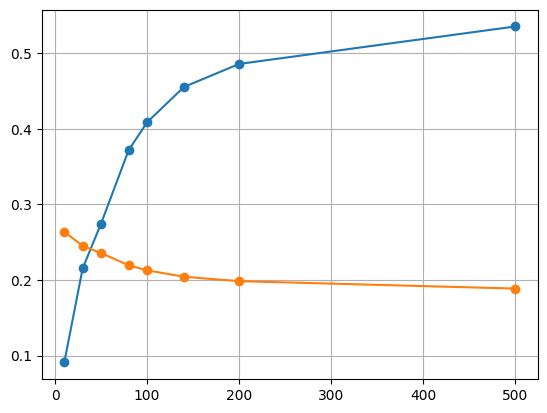

In [60]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = LinearRegression(n_jobs=10)
test_KPCA("Standard", threshold, mdl, X_train_scaled)

mdl = LinearRegression(n_jobs=10)
test_KPCA("Power Transformer", threshold, mdl, X_train_power_t)

mdl = LinearRegression(n_jobs=10)
test_KPCA("Quality normal", threshold, mdl, X_train_normal_transform)

mdl = LinearRegression(n_jobs=10)
test_KPCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = LinearRegression(n_jobs=10)
test_KPCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### K-neighbors Regressor

Standard
RVE: 0.5863111511645529
RMSE: 0.17794049533106265


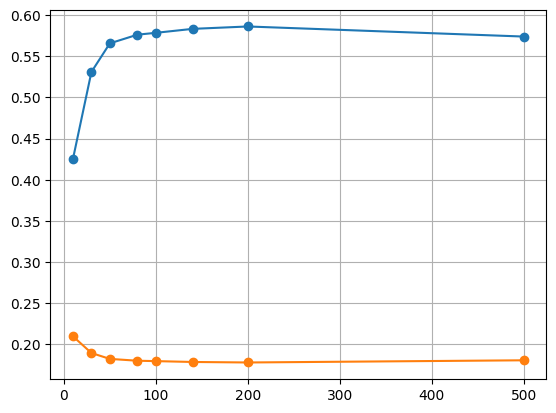

Power Transformer
RVE: 0.5891231807445927
RMSE: 0.17733057949647107


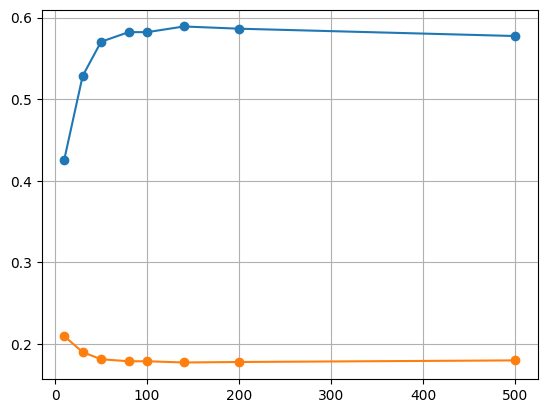

Normalizer
RVE: 0.45650387490614697
RMSE: 0.204778143445032


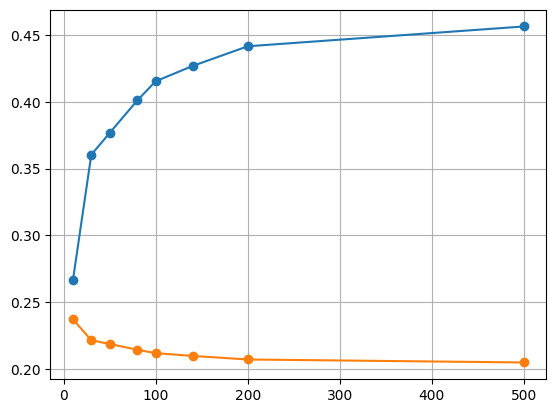

In [61]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = KNeighborsRegressor(n_jobs=6)
test_KPCA("Standard", threshold, mdl, X_train_scaled)

mdl = KNeighborsRegressor(n_jobs=6)
test_KPCA("Power Transformer", threshold, mdl, X_train_power_t)

# mdl = KNeighborsRegressor(n_jobs=6)
# test_KPCA("Quality normal", threshold, mdl, X_train_normal_transform)

# mdl = KNeighborsRegressor(n_jobs=6)
# test_KPCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = KNeighborsRegressor(n_jobs=6)
test_KPCA("Normalizer", threshold, mdl, X_train_normalizer_t)

#### Support Vector Regressor

Standard
RVE: 0.6376700828477355
RMSE: 0.16655819742072084


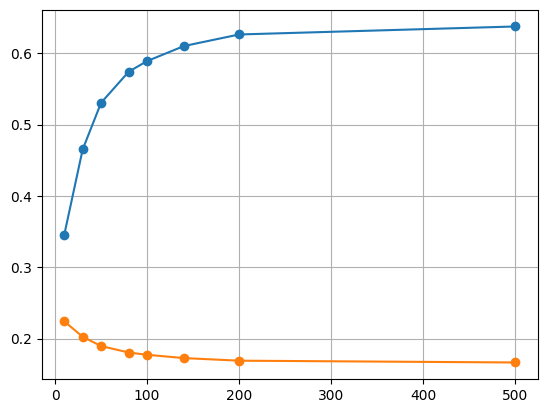

Power Transformer
RVE: 0.639458187980898
RMSE: 0.1661473779342361


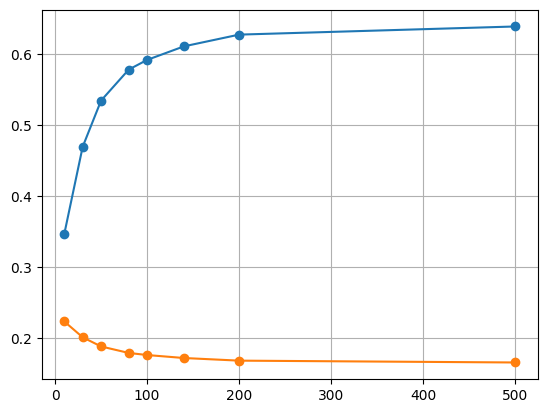

Normalizer
RVE: 0.6059567620342128
RMSE: 0.17365365495454993


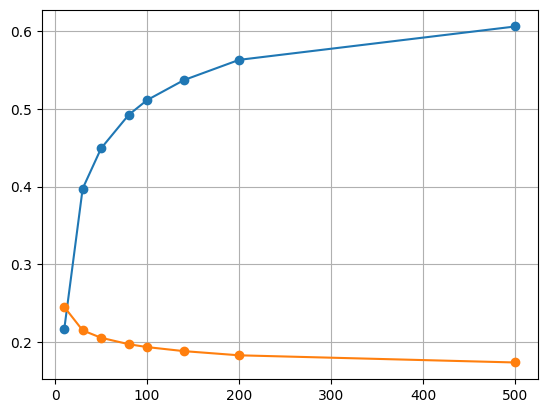

In [62]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]


mdl = SVR()
test_KPCA("Standard", threshold, mdl, X_train_scaled)

mdl = SVR()
test_KPCA("Power Transformer", threshold, mdl, X_train_power_t)

# mdl = SVR()
# test_KPCA("Quality normal", threshold, mdl, X_train_normal_transform)

# mdl = SVR()
# test_KPCA("Quality Uniform", threshold, mdl, X_train_uniform_transform)

mdl = SVR()
test_KPCA("Normalizer", threshold, mdl, X_train_normalizer_t)

Random forest
RVE: 0.4100600560856539
RMSE: 0.21248256949751812


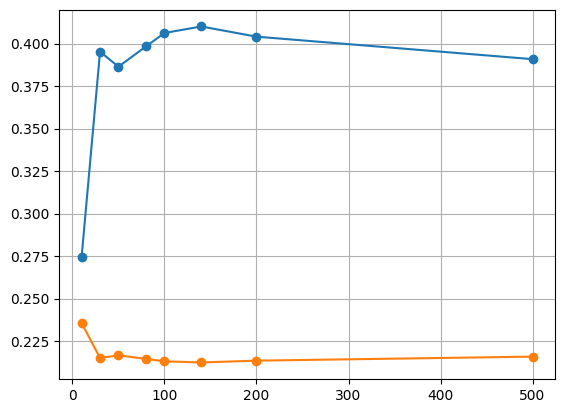

Linear Regression
RVE: 0.5293537987533754
RMSE: 0.18978345263730514


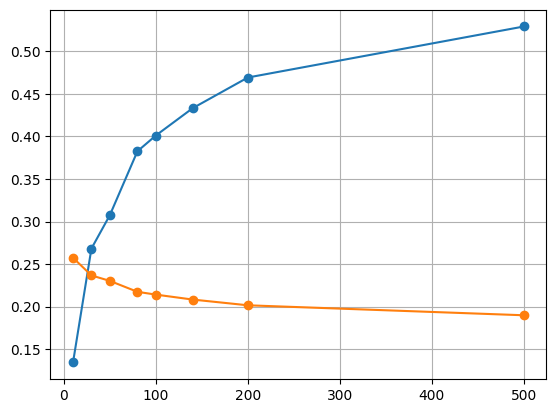

Decision Tree
RVE: 0.2718338019124933
RMSE: 0.23606282912729998


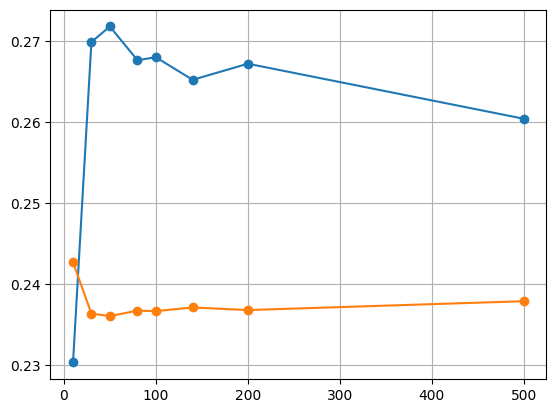

KNN
RVE: 0.6028217742842586
RMSE: 0.17434282425766956


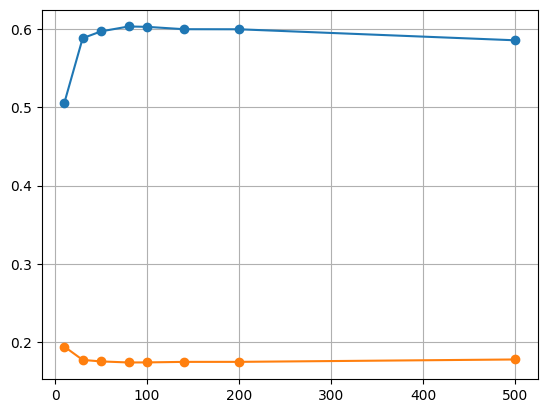

SVR
RVE: 0.6482962351965352
RMSE: 0.16408666558973306


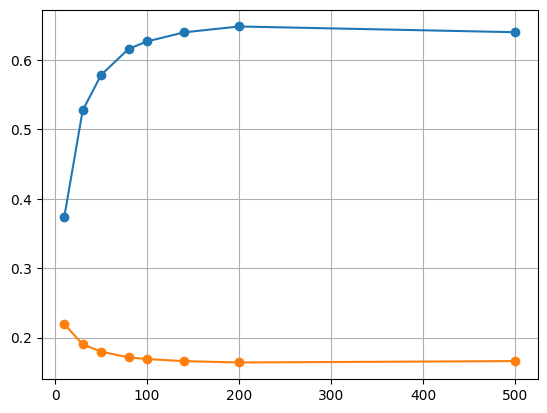

In [49]:
threshold = [10, 30, 50, 80, 100, 140, 200, 500]

RFR_mdl = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=3, max_depth = 8, n_jobs=6)
# nfold_valid(X_train_rffs, y_train, RFR_mdl)
test_PCA("Random forest", threshold, RFR_mdl, X_train)


LR_mdl = LinearRegression(n_jobs=6)
# nfold_valid(X_train_rffs, y_train, LR_mdl)  
test_PCA("Linear Regression", threshold, LR_mdl, X_train_scaled)


KNN_mdl = KNeighborsRegressor(n_jobs=6)
# nfold_valid(X_train_rffs, y_train, KNN_mdl)
test_PCA("KNN", threshold, KNN_mdl, X_train_scaled)


SVR_mdl = SVR()
# nfold_valid(X_train_rffs, y_train, SVR_mdl)
test_PCA("SVR", threshold, SVR_mdl, X_train_scaled)

In [108]:
final_scaler = StandardScaler()
# final_scaler = PowerTransformer()
# final_scaler = QuantileTransformer(output_distribution="uniform", random_state=0)
final_scaler.fit(X_train)
X_train_power_t_final = final_scaler.transform(X_train)
X_ivs_power_t_power = final_scaler.transform(X_ivs)

pca = PCA(n_components = 1000)
X_train_pca_final = pca.fit_transform(X_train_power_t_final)
X_ivs_pca = pca.transform(X_ivs_power_t_power)

mdl = SVR()
# mdl = KNeighborsRegressor(n_jobs=8)
# mdl = LinearRegression(n_jobs=10)
# mdl = MLPRegressor(solver='adam', max_iter=1000, alpha=0.01, activation="tanh", hidden_layer_sizes=[100, 50, 25])
# mdl = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27)

nfold_valid(X_train_pca_final, y_train, mdl)
# mdl.fit(X_train_pca_final, y_train)
preds = mdl.predict(X_ivs_pca)

preds = np.round(preds, 3)
for pred in preds:
    print(pred)

 The RVE is:  0.6282628068936364
 The rmse is:  0.16878028022326638
 The Correlation Score is: 0.7967 (p-value=0.000000e+00)

 The Maximum Error is:  0.8421368582290012
 The Mean Absolute Error is: 0.1306864343112841 

0.059
0.634
0.33
0.378
0.062
0.085
0.362
0.573
0.238
0.659
0.549
0.499
0.462
0.125
0.274
0.147
0.224
0.347
0.412
-0.007
0.969
0.315
0.406
0.186
0.092
0.394
0.17
0.128
0.228
0.214
0.191
0.45
0.249
0.508
0.77
0.277
0.228
0.543
0.359
0.375
0.179
0.078
0.148
0.444
0.262
0.447
0.793
0.161
0.333
0.274
0.367
0.269
0.101
0.203
0.285
0.8
0.45
0.153
0.475
0.682
0.301
0.577
0.519
0.361
0.599
0.304
0.448
0.337
0.523
0.112
0.293
0.185
0.397
0.216
0.381
0.277
0.587
0.718
0.264
0.083
0.557
0.283
0.524
0.178
0.44
0.217
0.343
0.378
0.275
0.816
0.107
0.509
0.453
0.351
0.224
0.488
0.323
0.536
0.438
0.279
0.368
0.441
0.18
0.227
0.287
0.422
0.29
0.124
0.273
0.296
0.31
0.273
0.631
0.252
0.253
0.567
0.433
0.251
0.699
0.372
-0.021
0.161
0.166
0.385
0.394
0.577
0.321
0.237
0.321
0.184
0.378
0.25